# Wetland water depth analyses <img align="right" src="../../Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with the `NCI`|`DEA Sandbox` environment
* **Products used:** 

* **Special requirements:** An _optional_ description of any special requirements, e.g. If running on the [NCI](https://nci.org.au/), ensure that `module load otps` is run prior to launching this notebook
* **Prerequisites:** An _optional_ list of any notebooks that should be run or content that should be understood prior to launching this notebook

## Background
An *optional* overview of the scientific, economic or environmental management issue or challenge being addressed by Digital Earth Australia. 
For `Beginners_Guide` or `Frequently_Used_Code` notebooks, this may include information about why the particular technique or approach is useful or required. 
If you need to cite a scientific paper or link to a website, use a persistent DOI link if possible and link in-text (e.g. [Dhu et al. 2017](https://doi.org/10.1080/20964471.2017.1402490)).

## Description
A _compulsory_ description of the notebook, including a brief overview of how Digital Earth Australia helps to address the problem set out above.
It can be good to include a run-down of the tools/methods that will be demonstrated in the notebook:

1. First we do this
2. Then we do this
3. Finally we do this

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [244]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import sys
import xarray as xr
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Polygon, shape
import rasterio.features
import rasterio.mask
import datacube
from datacube.utils import geometry
import scipy.signal, scipy.ndimage
from affine import Affine

sys.path.append('../../Scripts')
from dea_datahandling import load_ard
from dea_bandindices import calculate_indices
from dea_spatialtools import subpixel_contours

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set up functions
These functions are used for the analysis.

In [2]:
def get_water_level(geom, dem, x_offsets=[0], y_offsets=[0]):  
        
    '''
    Takes a shapely geometry (either LineString or MultiLineString) and a Digital Elevation
    Model (DEM), and samples values from the DEM based on line vertices. These values are used
    to return the median and standard deviation of elevation, which can subsequently be used
    to compute volume (and uncertainty) based on the same DEM.
    
    Optionally, this function can be run with a set of x and y offset values, which shuffle 
    the geometry object left, right, up and down, and returns values for the combination 
    with the lowest standard deviation. This is intended to account for 'jitter' caused by 
    poor co-registration/georeferencing in the Sentinel 2 imagery. This is experimental, and
    should be used with caution.
    
    Last modified: March 2019
    Author: Robbi Bishop-Taylor
    
    Parameters
    ----------    
    geom : Shapely LineString or MultiLineString
        Shapely geometry for the waterline being analysed
    dem : array
        A 2D digital elevation model (DEM) in the form of a numpy or xarray array.
    x_offsets : list, optional
        A list giving a series of amounts in metre units to shuffle the geometry east and west.
        The default is [0], which does no shuffling. E.g. setting `x_offsets=[-10, 0, 10]`
        will shuffle the geometry west and east by 10 m, and return results for the offset which
        produces the lowest standard deviation in extracted elevation values.
    y_offsets : list, optional
        A list giving a series of amounts in metre units to shuffle the geometry north and south.
        The default is [0], which does no shuffling. E.g. setting `y_offsets=[-10, 0, 10]`
        will shuffle the geometry north and south by 10 m, and return results for the offset which
        produces the lowest standard deviation in extracted elevation values.
        
    Returns
    -------
    offset_min_std : Pandas DataFrame
        A Pandas dataframe with columns giving `x_offset', 'y_offset`, `water_level` and 
        `water_level_std` values. `x_offset', 'y_offset` give the offset values which resulted
        in the lowest standard deviation of elevation values, while `water_level` and 
        `water_level_std` return the corresponding median and standard deviation elevation values
        themselves.
    '''
    
    # First try extracting line vertex coordinates from a Shapely LineString
    try: 
        xx, yy = geom.coords.xy
        xx = np.array(xx)
        yy = np.array(yy)

    # If this fails, extract line vertex coordinates as if data is a Shapely MultiLineString
    except:

        xx = np.concatenate([i.coords.xy[0] for i in geom])
        yy = np.concatenate([i.coords.xy[1] for i in geom]) 
        
    # Convert coordinates to xarray DataArrays to facilitate fast extraction of elevation values
    xx = xr.DataArray(xx, dims='z')
    yy = xr.DataArray(yy, dims='z')
    
    # Iterate through all combinations of x and y offsets
    all_offsets = []    

    for x_offset, y_offset in itertools.product(x_offsets, y_offsets):        

        # Sample DEM to extract elevations for each vertex coordinate
        sampled_elevs = dem.interp(x=xx + x_offset, y=yy + y_offset).values

        # Compute median and standard deviation elevation values, and add to list
        all_offsets.append(((x_offset, y_offset, np.nanmedian(sampled_elevs), np.nanstd(sampled_elevs))))

    # From the dataframe of resulting water_levels and water_level_stds for different xy offsets, 
    # select the row with the lowest standard deviation in elevation values.
    offset_df = pd.DataFrame(all_offsets, columns=['x_offset', 'y_offset', 
                                                   'water_level', 'water_level_std'])
    offset_min_std = offset_df.iloc[offset_df.water_level_std.idxmin()]

    return offset_min_std 


def level_to_volume(level_m, dem, resolution, clip_max=True):
    
    '''
    Applies a given water level to a DEM, and computes the total volume
    of the area filled with water in megalitre (Ml) units.
    
    Last modified: March 2019
    Author: Robbi Bishop-Taylor
    
    Parameters
    ----------    
    level_m : int or float
        Water level of dam/reservoir in metre units.
    dem : array
        A 2D digital elevation model (DEM) in the form of a numpy or xarray array.
    resolution : tuple
        A tuple giving the x and y resolutions of the DEM.
    clip_max : bool, optional
        An optional boolean indicating whether to restrict water levels to the highest 
        elevation in the DEM. The default is True, which prevents artificially high
        volumes being computed where water levels are higher than the top of the dam.
        
    Returns
    -------
    total_volume : int or float
        A numeric value giving the computed volume in megalitre (Ml) units
    '''
    
    # If water level is above highest point in DEM, use the highest elevation in 
    # the DEM instead of the supplied water level
    if clip_max:
        level_m = np.min([level_m, dem.max().item()])
        
    # Create a flat array with values set to the given water level
    water_level = np.full(dem.shape[1:], level_m)
    
    # Subtract LiDAR DEM from this water level array to create an array giving the 
    # difference between this water level and the true elevation of each pixel
    water_level_diffs = water_level - dem
    
    # By restricting these differences to only pixels where the water level is
    # higher than the underlying LiDAR DEM (i.e. positive values), we can get
    # depths for every pixel
    water_level_depths = water_level_diffs.where(water_level_diffs > 0)
    
    # By multiplying depths by the area of each pixel (obtained from the resolution
    # of the LiDAR raster), we can compute volumes in cubic metres for each pixel
    water_level_volumes = water_level_depths * (resolution[0] * resolution[1])   
    
    # Finally, sum the volumes of all pixels and multiply by 0.001 to get total 
    # waterbody volume in megaliters (Ml) for the given water level height
    total_volume = water_level_volumes.sum().item() * 0.001

    # Return volume     
    return total_volume

def identify_outliers(data, m = 3):
    
    '''
    Function takes an array of values, and returns a boolean array
    of the same length which flags values as outliers according to the 
    standard deviation m. 
    '''
    
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d / mdev if mdev else 0.
    return s < m

### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [3]:
dc = datacube.Datacube(app='Wetland_volumes')

### Analysis parameters

The following parameters will need to be set prior to running this notebook:

#### LiDAR parameters
* `LiDARtifFile`: A string pointing to the location of the lidar file to read in for the analysis. Note that this code currently assumes that this is a geotiff file.
* `flatness_threshold`: e.g. 0. How much variability in the LiDAR DEM we are considering to be 'flat'. This is in the same units as the LiDAR DEM. This allows for some small variance to still be considered a uniform flat surface. This parameter is used for detecting water in the LiDAR scene.
* `count_threshold`: e.g. 1500. If a number appears in the LiDAR DEM more than `count_threshold` times, then it is considered in the final array. This allows us to only look for large, flat areas, like water. We choose to set this to 1500, which equates to half of the area of the smallest waterbody identified in DEA Waterbodies, or 2.4 Landsat 25m pixels.
#### Vegetation shapefile parameters
* `VegShapeFile`: A string pointing to the location of the vegetation communities file to read in for the analysis. Note that this code currently assumes that this is a shape file.
* `VegShapeFileVegNameColumn`: A name string pointing to the column/attribute in the shapefile that contains the vegetation community names. This column will be used to group polygons within the shapefile that belong to the same vegetation community, and to generate labels for vegetation types being mapped.
* `VegShapeFileVegNameUIDColumn`: A name string pointing to the column/attribute in the shapefile that contains a numerical ID that corresponds to the vegetation community names. This numerical ID is used in place of the `VegShapeFileVegNameColumn` to burn into the shapefile when it is converted from a shapefile to a raster. This then alows us to map back to the vegetation community types. If there is no numerical ID that is related to the vegetation types, use `None`, and we will generate one in the code below.
#### Satellite data parameters
* `minimum_cloudfree_perc`: e.g. 0.8. A float between 0 and 1 of the minimum proportion of cloud free pixels used to return cloud-free images. A value of 0.9 means that at least 90% of the tile must be cloud free to be included. Use a lower threshold to include more data, but increase the chance of clouds in the analysis. 
* `time_period`: e.g. ('2016', '2017'). The start and end dates for the satellite data extraction. Keep this window small to avoid loading in too much data at once. 

In [27]:
#LiDARtifFile = 'InputData/MacMarshesLiDAR1mDEM2014/MacMarshes2014Sth3577.tif'
LiDARtifFile = 'InputData/CLIP3577.tif'
flatness_threshold = 0 
count_threshold = 1500

VegShapeFile = 'InputData/MacquarieMarshes_2008_E_39203577.shp'
VegShapeFileVegNameColumn = 'Species_1'
VegShapeFileVegNameUIDColumn = None

minimum_cloudfree_perc = 0.8
time_period = ('2016', '2017')

## Load in the LiDAR data

The LiDAR data have come from Geoscience Australia's [ELVIS platform](https://elevation.fsdf.org.au/). We chose to use 1m DEM data, and downloaded it as a Geotiff file. The LiDAR data comes with its own projection system. We use `GDAL` to reproject the LiDAR to `EPSG:3577` so it's in the same projection as the native DEA satellite data. This reprojection step only needs to be done once since it saves out the new reprojected file. The code we used for this step is in the cell below.

In [5]:
# Open the geotiff
LiDAR = xr.open_rasterio(LiDARtifFile)
# It's a single band dataset, so remove the superfluous band
LiDAR = LiDAR.squeeze()

### Convert to a dataset and create an anomaly from the lowest point in the lidar data


In [6]:
LiDARds = LiDAR.to_dataset(name='DEM')
LiDARds.attrs = LiDAR.attrs

# Replace missing values with nan
LiDARds['DEMNaN'] = LiDAR.where(LiDAR!=LiDAR.attrs['nodatavals'][0])

LiDARds['DEMAnom'] = LiDARds.DEMNaN - LiDARds.DEMNaN.min()

### Quick plot to see how it looks

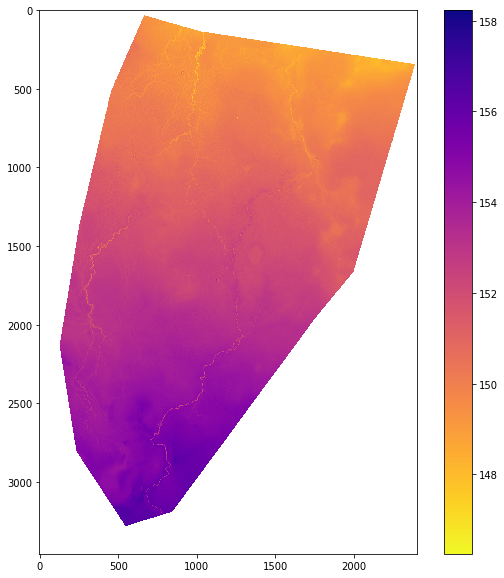

In [7]:
# plt.pcolor(LiDARds.x, LiDARds.y, LiDARds.DEMAnom, cmap='plasma_r')
# plt.colorbar()
fig = plt.figure(figsize=[10,10])
plt.imshow(LiDARds.DEMNaN, cmap='plasma_r')
plt.colorbar()

### How about in 3D?
Since this is lidar height data, we should plot it in 3D to see how it looks.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  """
/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


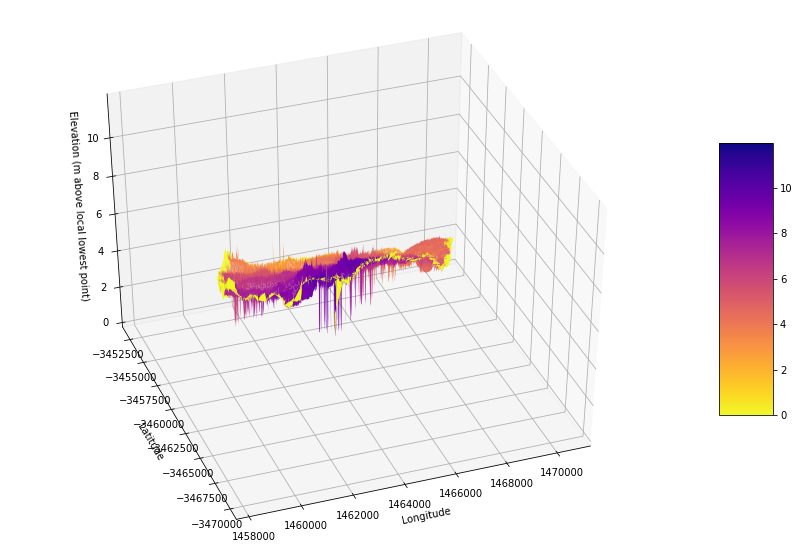

In [8]:
XX, YY = np.meshgrid(LiDARds.x, LiDARds.y)

fig = plt.figure(figsize=[15,10])
ax = fig.gca(projection='3d')
surf = ax.plot_surface(XX, YY, LiDARds.DEMAnom, cmap='plasma_r', vmin=0, vmax=LiDARds.DEMAnom.max())
# Change so that north is in the right place
# The first number is the up/down angle, the secodn is the left/right angle.
ax.view_init(40,-110)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Elevation (m above local lowest point)', rotation=180);

## Can we automatically detect water in the lidar data?

In some of the lidar plots explored so far, we can see that there are large flat bits of data that are either water, or very flat streambeds. Can we develop some code to automatically detect the presence of water in the lidar data, and therefore introduce a degree of uncertainty to our volume results?

The code below does this by looking for large flat areas within the lidar data. It first takes the DEM, then calculates the difference between subsequent values in both the x and y direction to calculate a gradient of elevation change. It then compares these differences to the `flatness_threshold`, which sets how much variability in the DEM we are considering to be 'flat'. This allows for some small variance to still be considered a uniform flat surface. 

Once we've determined where the data are sufficiently 'flat', the data are smoothed using `scipy.signal.convolve2d`, then small 'bits' of elevation change are removed by using `scipy.ndimage.binary_opening`, which erodes and then dilates the array. The erode removes small and/or narrow data pieces, which are then not included in the subsequent dilation, removing them from the array. 

Finally, the code counts up the number of each unique number in the array, and tallys how many times it appears. If a number appears more than `count_threshold` times, then it is considered in the final array. 

In [9]:
# Check whether subsequent numbers are the same to determine the gradient of the DEM
x = np.diff(LiDARds.DEMNaN, axis=1)
y = np.diff(LiDARds.DEMNaN, axis=0)

# Is the difference small enough to be considered 'flat'?
z = (np.absolute(x) <= flatness_threshold)[1:] & (np.absolute(y) <= flatness_threshold)[:,1:]
# Does some initial smoothing
z = scipy.signal.convolve2d(z, np.ones((2, 2))) == 4
# Erodes and then dilates the data to remove small 'bits'
z = scipy.ndimage.binary_opening(z, iterations=1)

# Find how many unique numbers are in the data (within the z mask), and count their occurance
val, count = np.unique(LiDARds.DEMNaN.values[z], return_counts=True)
# Compare the count to the count threshold
val = val[count > count_threshold]
# Just return data where it reaches the count threshold
dupes = np.isin(LiDARds.DEMNaN, val)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  


### Plot the results

If we have water in the LiDAR scene, it will show up as yellow in the plots below.

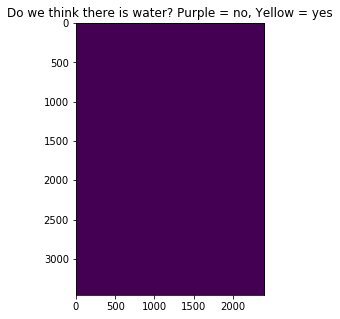

In [10]:
fig = plt.figure(figsize=[5,5])
plt.imshow(dupes);
plt.title('Do we think there is water? Purple = no, Yellow = yes');

### Put the results back into our array to use as a mask later on

In [11]:
LargeFlat = xr.DataArray(dupes,
                         coords=[LiDARds.y, LiDARds.x],
                         dims=['y', 'x'],
                         name='Water',
                         attrs=LiDARds.attrs)
LiDARds['Water'] = LargeFlat

## Extract depth contours from the LiDAR

In [13]:
# Extract waterline contours for the supplied water index threshold:
contour_gdf = subpixel_contours(da=LiDARds.DEMNaN,                               
                                z_values= np.arange(start=LiDARds.DEMNaN.min(), stop=LiDARds.DEMNaN.max(), step=1),
                                crs=LiDARds.attrs['crs'],
                                affine=Affine(5.023973751531518,0.0,1458393.643394294,0.0,-5.023973751531518,-3452367.6886073104))

Operating in multiple z-value, single array mode


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:422: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  projstring = _prepare_from_string(projparams)


Failed to generate contours: 146.251647


In [36]:
LiDARds.attrs['transform']

(5.023973751531518,
 0.0,
 1458393.643394294,
 0.0,
 -5.023973751531518,
 -3452367.6886073104)

In [60]:
crs=Affine(5.235621652763951e-05,0.0,147.4716201280101,0.0,-4.511400220517699e-05,-30.896889055329364)

In [61]:
crs.a

5.235621652763951e-05

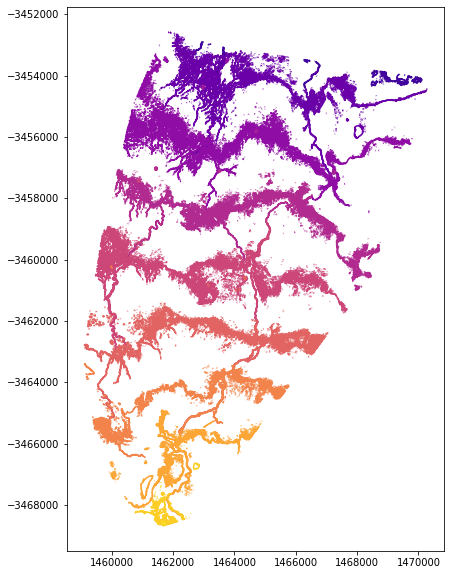

In [14]:
contour_gdf.plot(figsize=(15, 10), cmap = 'plasma')

## Load in the vegetation communities shapefile

For the Macquarie Marshes, we used data from the [NSW government](https://datasets.seed.nsw.gov.au/dataset/macquarie-marshes-vegetation1991-2008-vis_id-3920ff230/resource/3f102578-05ba-4a59-854d-fddd9ab27f53).

As with the lidar data, we need to reproject it to `EPSG:3577` so it's in the same projection as the native DEA satellite data. This reprojection step only needs to be done once since it saves out the new reprojected file. The code we used for this step is in the cell below.

In [15]:
VegComm = gpd.read_file(VegShapeFile) 

## Clip the vegetation shapefile to the extent of the LiDAR data
The vegetation community shapefile covers a much larger geographical extent than the LiDAR data, which is provided in small tiles due to its size. We need to clip down the veg data so we can just deal with the veg data that covers the LiDAR data extent.

### Create a mask the same size as the LiDAR data

In [282]:
# Make a boolean mask for data/nan
rasterMask = ~np.isnan(LiDARds.DEMNaN)
# Convert the raster to polygons 
# We use a mask of '1' to only generate polygons around values of '1' (not NaNs)
LiDARPolygonMask = rasterio.features.shapes(rasterMask.data.astype('float32'), 
                                mask=rasterMask.data.astype('float32') == 1,
                                transform = LiDARds.transform)
# The rasterio.features.shapes returns a tuple. We only want to keep the geometry portion,
# not the value of each polygon (which here is just 1 for everything)
LiDARPolygonMaskbreaktuple = (a for a, b in LiDARPolygonMask)
LiDARPolygonMaskGP = gpd.GeoDataFrame(list(LiDARPolygonMaskbreaktuple), crs='EPSG:3577')
LiDARPolygonMaskGP['geometry'] = None
for ix, poly in LiDARPolygonMaskGP.iterrows():
    poly['geometry'] = shape(poly)
LiDARPolygonMaskGP = LiDARPolygonMaskGP.drop(columns=['type', 'coordinates'])

### Now clip the shapefile with the extents of the mask

In [284]:
ClippedVeg = gpd.clip(VegComm, LiDARPolygonMaskGP)

/usr/local/lib/python3.6/dist-packages/geopandas/geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


### And plot it to make sure it looks reasonable

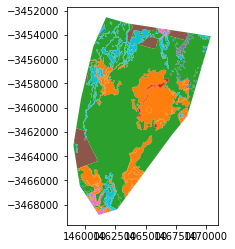

In [285]:
ClippedVeg.plot(column = VegShapeFileVegNameColumn)

## Assign a random numerical ID for each vegetation species
This is so we can burn it into the raster we create in the next step. 

If each vegetation community already has a numerical ID, set this parameter in `VegShapeFileVegNameUIDColumn` above. If it is set to `None` - i.e. doesn't already exist, we will generate one here.

In [286]:
if VegShapeFileVegNameUIDColumn:
    # if it already exists, copy it to 'RandomUID'
    ClippedVeg['RandomUID'] = ClippedVeg[VegShapeFileVegNameUIDColumn]
else:
    # else use groupby and ngroup to make one
    ClippedVeg['RandomUID'] = ClippedVeg.groupby(VegShapeFileVegNameColumn).ngroup()

# Grab all the unique ID numbers
unique_combinations = ClippedVeg[['RandomUID', VegShapeFileVegNameColumn]].drop_duplicates()
# Create a dict to map between the number and the species name string
SpeciesDict = dict(zip(unique_combinations.RandomUID, unique_combinations.Species_1))

## Rasterize the vegetation shapefile

We would like to have the vegetation communities and the LiDAR DEM both on the same grid (so we don't have to keep comparing raster and vector file formats). 
To do this we will use the random veg ID and make this the value of the raster file at that location. 

In [287]:
# Grab just the geometry and the numerical ID from the ClippedVeg shapefile
# (we don't need any of the other information)
shapes = zip(ClippedVeg['geometry'], ClippedVeg['RandomUID'])
# Grab the spatial information from the LiDAR data so we can project to the same raster grid
transform = LiDARds.attrs['transform']
y, x = LiDARds.DEM.values.shape

# Now convert the polgons into a numpy array
RasterVeg = rasterio.features.rasterize(shapes=shapes,
                                        out_shape=(y, x),
                                        all_touched=False,
                                        fill=np.nan,
                                        transform=transform)

# Convert result to a xarray.DataArray using coords etc from the LiDAR data
RasterVeg = xr.DataArray(RasterVeg,
                         coords=[LiDARds.y, LiDARds.x],
                         dims=['y', 'x'],
                         name='veg_randomUID',
                         attrs=LiDARds.attrs)

# Convert to xarray dataset to assist with writing to GeoTIFF
RasterVeg = RasterVeg.to_dataset()
# Copy over the atributes
RasterVeg.attrs = LiDARds.attrs

### Combine the LiDAR DEM and the rasterized vegetation data

This way we have one dataframe with both a DEM height, and a vegetation community.

In [288]:
CombineLiDARVeg = RasterVeg.merge(LiDARds)

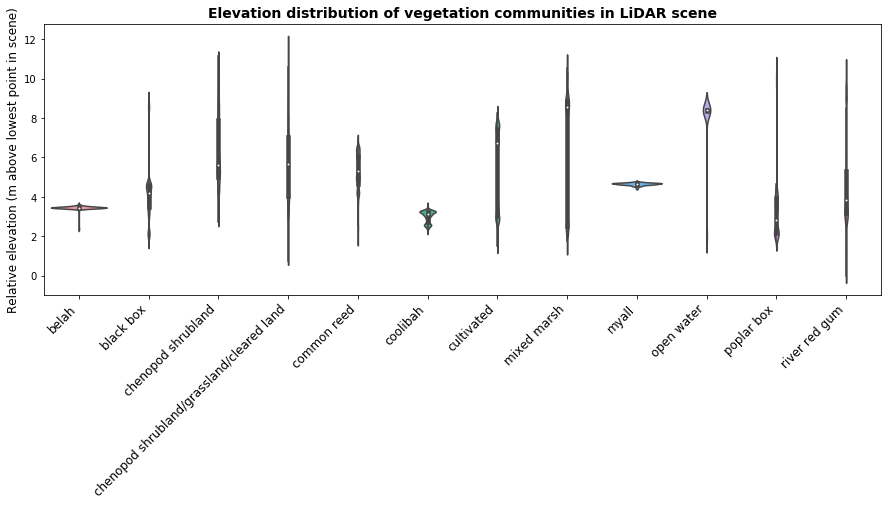

In [289]:
fig = plt.figure(figsize=[15,5])
ax = sns.violinplot(x=CombineLiDARVeg['veg_randomUID'].values.flatten(), y=CombineLiDARVeg['DEMAnom'].values.flatten())
ax.set_xticklabels(sorted(SpeciesDict.values()), rotation=45, ha='right', fontsize=12);
plt.ylabel('Relative elevation (m above lowest point in scene)', fontsize = 12);
plt.title('Elevation distribution of vegetation communities in LiDAR scene', fontsize = 14, fontweight = 'bold');

## Now we need to map our elevation/vegetation back to water observations

### Load in some satellite data

In [47]:
# Get spatial extent bounds from dimensions of LiDAR data
ymin = LiDAR.y.min().item()
ymax = LiDAR.y.max().item()
xmin = LiDAR.x.min().item()
xmax = LiDAR.x.max().item()

query = {'x': (xmin, xmax),
         'y': (ymax, ymin),
         'time': time_period,
         'crs': LiDAR.crs,
         'measurements': ['nbart_red', 'nbart_blue', 'nbart_green', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2'],
         'resolution': (-100, 100),
         'output_crs': LiDAR.crs,
         'resampling': {'fmask': 'nearest', '*': 'average'}, 
        }

# Load in only satellite observations with less than minimum_cloudfree_perc clear pixels
satellite_ds = load_ard(dc=dc, 
                        products=['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3'],
                        min_gooddata=minimum_cloudfree_perc,
                        **query)

Loading ga_ls5t_ard_3 data
    No data for ga_ls5t_ard_3
Loading ga_ls7e_ard_3 data
    Filtering to 57 out of 75 observations
    Applying pixel quality mask
Loading ga_ls8c_ard_3 data
    Filtering to 72 out of 89 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 129 observations 


### Mask the data that have been returned using the spatial footprint of LiDAR

In [312]:
SatelliteMask = rasterio.features.geometry_mask(LiDARPolygonMaskGP.iloc[0],
                                      out_shape=(len(satellite_ds.y), len(satellite_ds.x)),
                                      transform=satellite_ds.geobox.transform,
                                      invert=True)
SatelliteMask = xr.DataArray(SatelliteMask, dims=("y", "x"))

In [313]:
SatelliteDSmasked = satellite_ds.where(SatelliteMask == True)

### Calculate wetness index

Here we use the Tasselled Cap Wetness Index from [Crist 1985](https://doi.org/10.1016/0034-4257(85)90102-6).

This index can be used to identify water and wet vegetation, using the thresholds below. Note that these are rough, and may need to be modified depending on the area in which you are applying this index. 

* <-1200 -- becoming progressively less wet. 
    * The TCW is a continuous index. 
* -1200 -- ‘wettish’
    * Useful for identifying springs or boggy ground, may capture wet vegetation 
* -600 -- ‘wet’ 
    * Useful for identifying a combination of open water and wet vegetation 
* -350 -- ‘wet according to the Mac Marshes project’ 
    * A rough threshold set for the tasselled cap wetness for the Macquarie Marshes, to match up with work by Thomas et al. (2015) on mapping the inundation associated with flow events, was -350 for visibly (from a helicopter) inundated vegetation and water for one event. 
* 0 –- useful threshold for identifying areas of open water. 
    * Values of 0 and above generally correspond to Water Observations from Space (WOfS) areas classified as open water. 

In [314]:
# Compute Tasselled Cap Wetness Index (TCW)
SatelliteIndices = calculate_indices(SatelliteDSmasked, 
                                 index='TCW', 
                                 collection='ga_ls_3',
                                 normalise=False
                                )

../../Scripts/dea_bandindices.py:263: UserWarning: 
A coefficient-based index ('TCW') normally applied to surface reflectance values in the 
0.0-1.0 range was applied to values in the 0-10000 range. This can produce unexpected results; 
if required, resolve this by setting `normalise=True`
  warnings.warn(f"\nA coefficient-based index ('{index}') normally "


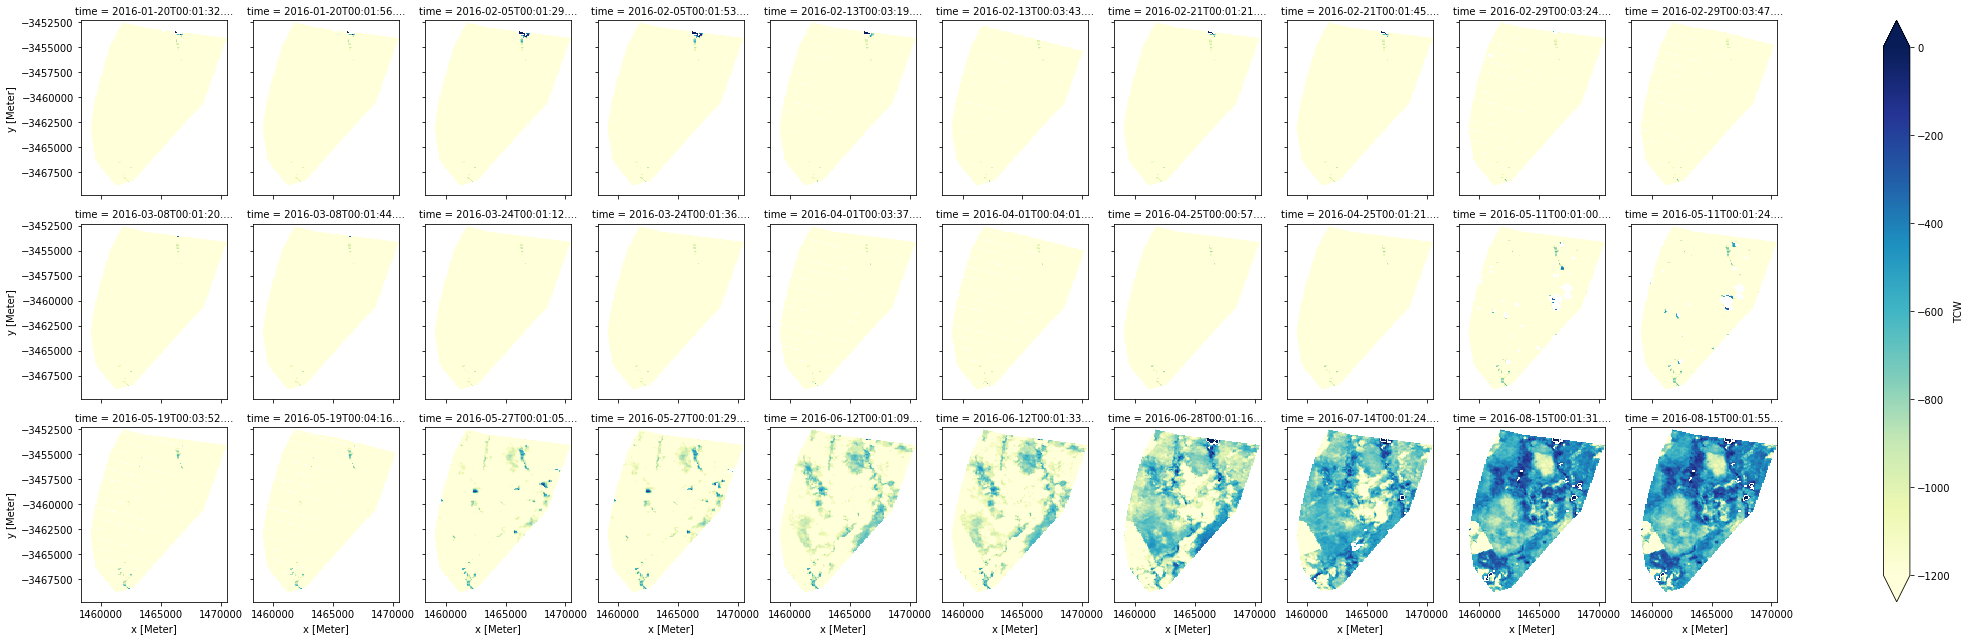

In [315]:
# Preview results for the first 30 observations
SatelliteIndices.TCW.isel(time=slice(0, 30)).plot.imshow(col='time',
                                                       col_wrap=10,
                                                       vmin=-1200, 
                                                       vmax=0,
                                                       cmap='YlGnBu',
                                                       add_labels=False)

### Plot some Landsat data over the top to show the scale of each dataset

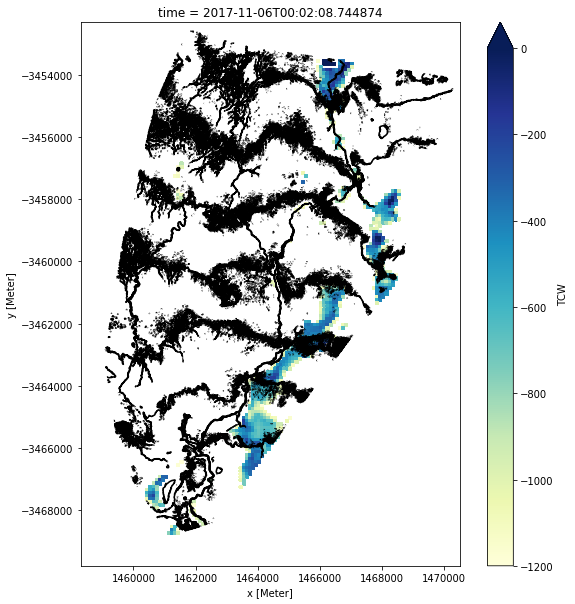

In [316]:
contour_gdf.plot(figsize=(10, 10), color = 'k')
SatelliteIndices.TCW.where(SatelliteIndices.TCW>=-1200).isel(time=120).plot(vmin=-1200, vmax=0, cmap='YlGnBu')